In [1]:
import keras
from keras.layers import LeakyReLU, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape, Activation
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from os import walk
import matplotlib.image as mpimg

Using TensorFlow backend.
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\fra

In [2]:
batch_size = 256
epochs  = 50000
noise_size = 100

In [3]:
# with colab:
#!unzip pokemon_small.zip

In [4]:
#------------------------------------------------------------------------------------
# Define the generator - take noise and convert them to images
#------------------------------------------------------------------------------------
def generator():
    generator=Sequential()
    
    # output: 8*8*512
    generator.add(Dense(8*8*512, input_shape=(noise_size,)))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    #output: (8,8,512)
    generator.add(Reshape((8, 8, 512)))
    generator.add(Dropout(0.5)) 
   
    # output: (8,8,256)
    generator.add(Conv2DTranspose(256, kernel_size=(5,5), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    # output: (16,16,128)
    generator.add(Conv2DTranspose(128, strides=(2, 2), kernel_size=(5,5), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))
    
    # output: (32,32,64)
    generator.add(Conv2DTranspose(64, strides=(2, 2), kernel_size=(5,5), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))
    
    # output: (64,64,3)
    generator.add(Conv2DTranspose(3, strides=(2, 2), kernel_size=(5,5), padding='same', activation='sigmoid'))
    
    return generator

g=generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (C

In [6]:
#-------------------------------------------------------------------------------------------
# Define the Discriminator - take both real images and synthetic fake images 
# from Generator and classify the real and fake images properly
#-------------------------------------------------------------------------------------------
def discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(1, activation='sigmoid'))

    return model

d=discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
__________

In [7]:
# the trainable discriminator model with binary crossentroy loss and RMS optimizer
def discriminator_model():
    optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
    model = Sequential()
    model.add(d)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

dm = discriminator_model()
dm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 1)                 1045633   
Total params: 1,045,633
Trainable params: 1,045,633
Non-trainable params: 0
_________________________________________________________________


In [8]:
# the trainable adversarial model with binary crossentroy loss and RMS optimizer
def adversarial_model():
    # we don't train the discriminator when we train the generator
    for layer in d.layers:
        layer.trainable=False
        
    optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
    model = Sequential()
    model.add(g)
    model.add(d)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

am = adversarial_model()
am.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         7748483   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1045633   
Total params: 8,794,116
Trainable params: 7,682,051
Non-trainable params: 1,112,065
_________________________________________________________________


In [9]:
#----------------------------------------------------------------------------
# Read the dataset
#----------------------------------------------------------------------------
imgs = []

f = []
for (dirpath, dirnames, filenames) in walk('pokemon_small'):
    f.extend(filenames)

for src in f:
    #read PNG images and convert them to RGB tensors
    # on colab: 'pokemon_small/'
    img = mpimg.imread('pokemon_small\\' + src)[:,:,0:3]
    imgs.append(img)
    
imgs = np.array(imgs)

In [10]:
# in this version, we train the discriminator and adversarial model separately if the accuracy of one model is much better than the other
def train():
    trainA, trainD = True, True
    for i in range(epochs):    
        if (trainD):
            imgs_train = imgs[np.random.randint(0,imgs.shape[0], size=batch_size), :, :, :]
            noise = np.random.normal(0, 1.0, size=[batch_size, noise_size])
            imgs_fake = g.predict(noise)
            x = np.concatenate((imgs_train, imgs_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = dm.train_on_batch(x, y)

        if (trainA):
            y = np.ones([batch_size, 1])
            noise = np.random.normal(0, 1.0, size=[batch_size, noise_size])
            a_loss = am.train_on_batch(noise, y)
        
        if (d_loss[1]*0.8 > a_loss[1]):
            trainA = True
            trainD = False
        elif (a_loss[1]*0.8 > d_loss[1]):
            trainA = False
            trainD = True
        else:
            trainA = True
            trainD = True
        
        if (i % 50 == 0):
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
        
        if (i % 500 == 0):
            am.save_weights("model"+str(i)+".h5")
            plot_images(fake = True)   

In [13]:
# plot 16 false images
def plot_images(save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'pokemon.png'
        if fake:
            if noise is None:
                noise = np.random.normal(0, 1.0, size=[samples, noise_size])
            else:
                filename = "pokemon_%d.png" % step
            images = g.predict(noise)
        else:
            i = np.random.randint(0, imgs.shape[0], samples)
            images = imgs[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [64, 64, 3])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

0: [D loss: 0.380687, acc: 0.820312]  [A loss: 0.000000, acc: 1.000000]


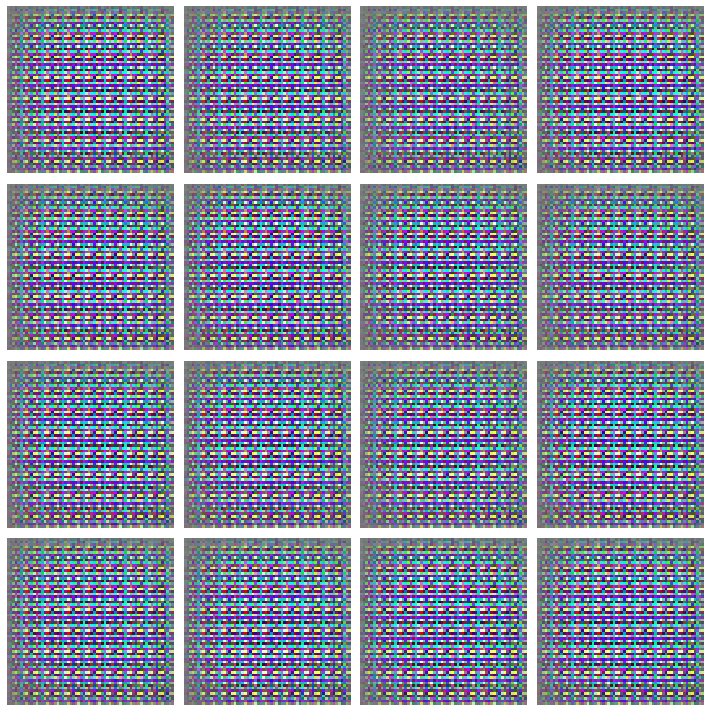

KeyboardInterrupt: 

In [14]:
#train the model
train()